In [161]:
import os
import re
#import ROOT
import hist
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
# iminuit
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)
import itertools
from collections import defaultdict

iminuit version: 2.30.1


In [386]:
data_storage = defaultdict(lambda: defaultdict(dict))

#tags = ["IPIP", "IPDP", "IPPV"]

tag = "IPDP"

catdict = {
    r"$\mu-\pi$"     : 20014002,
    r"$\mu-\rho$"    : 20014004,
    r"$\mu-a^{1}_{3\pi}$" : 20014008,
}

shiftdict = {
    "cp_even": {"shift": 150, "colour": "red", "location": "upper right"},
    "cp_odd": {"shift": 151, "colour": "blue", "location": "lower left"},
    "cp_maxmix": {"shift": 0, "colour": "black", "location": "lower right"},
}

simpledict = {
    r"$\mu-\pi$"     : "mupi",
    r"$\mu-\rho$"    : "murho",
    r"$\mu-a^{1}_{3\pi}$" : "mua13pr",
}

In [387]:
file = f"INPUT/shifted_hist__PhiCPGen_{tag}.pickle"

In [388]:
fileptr = open(file, 'rb')
data = pickle.load(fileptr)
fileptr.close()
data

Hist(
  IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category'),
  IntCategory([11100], growth=True, name='process'),
  IntCategory([0, 150, 151], growth=True, name='shift'),
  Variable([0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88496, 2.19911, 2.51327, 2.82743, 3.14159, 3.45575, 3.76991, 4.08407, 4.39823, 4.71239, 5.02655, 5.34071, 5.65487, 5.96903, 6.28319], name='PhiCPGen_IPDP', label='$\\Phi_{CP}^{IP-NP}$ (rad) [Gen level]'),
  storage=Weight()) # Sum: WeightedSum(value=13522.5, variance=64.9478)

In [389]:
axes = data.axes
category_axis  = axes['category']
category_axis

IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category')

In [390]:
shift_axis = axes['shift']
shift_axis

IntCategory([0, 150, 151], growth=True, name='shift')

In [391]:
cparray = {}
for ccat, cval in catdict.items():
    shiftarray = {}
    for shift, props in shiftdict.items():
        hypothesis = shift
        colour = props["colour"]
        location = props["location"]

        if cval not in category_axis:
            print(f"WARNING : {cval} not in categories")
            continue

        shift_index = shift_axis.index(props["shift"])
        values = data[category_axis.index(cval), :, shift_index, :].values()
        # https://github.com/oponcet/CPinHToTauTau/blob/FF_dev_project/script_FF/fake_factor_derivation/src/input_processing.py#L133
        errors = data[category_axis.index(cval), :, shift_index, :].variances() ** 0.5
        
        # store in data_storage
        shiftarray[hypothesis] = {  # Using `hypothesis` instead of `shift`
            "values": values,
            "errors": errors,
            "colour": colour,
            "location": location,
            "asymmetry_val": values,
            "asymmetry_error": errors,
        }

    cparray[ccat] = shiftarray
#cparray

In [392]:
def model(x, a, b, c):
    return a*np.cos(x+c) + b

def fit(x, y, err=0.05, model=model):
    lsq = LeastSquares(x, y, err, model)
    m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
    #m.scan(ncall=100)
    m.fixed = False
    m.migrad()  # finds minimum of least_squares function
    m.hesse()  # accurately computes uncertainties
    return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]

In [393]:
def comp_asymmetry(arr1, arr2):
    # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
    return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))

def comp_asymmetry_error(arr1, arr2, err1, err2): #arr = array of values, err = array of errors
    # Terms for partial derivatives
    denom = arr1 + arr2
    term1 = err1 * np.abs((2 * arr2) / (denom**2))
    term2 = err2 * np.abs((2 * arr1) / (denom**2))
    # Propagate errors
    sigma_A = np.sqrt(np.sum(term1**2 + term2**2)) / arr1.size
    return sigma_A

<>:90: SyntaxWarning: invalid escape sequence '\p'
<>:90: SyntaxWarning: invalid escape sequence '\p'
/var/folders/93/c9bkpqp16ljgrpm8vy_h3lzr0000gn/T/ipykernel_444/1342553898.py:90: SyntaxWarning: invalid escape sequence '\p'
  plt.title(f"{cat} ($A_{{even,odd}}$ = {asymmetry_val_even_odd_rounded}$\pm${asymmetry_error_even_odd_rounded})", fontsize=25, loc='center')


cat :  $\mu-\pi$
cat :  $\mu-\rho$
hyp :  cp_even shift_props : {'shift': 150, 'colour': 'red', 'location': 'upper right'}
hyp :  cp_odd shift_props : {'shift': 151, 'colour': 'blue', 'location': 'lower left'}
hyp :  cp_maxmix shift_props : {'shift': 0, 'colour': 'black', 'location': 'lower right'}
combo_name :  cp_even_vs_cp_odd
combo_name :  cp_even_vs_cp_maxmix
combo_name :  cp_odd_vs_cp_maxmix


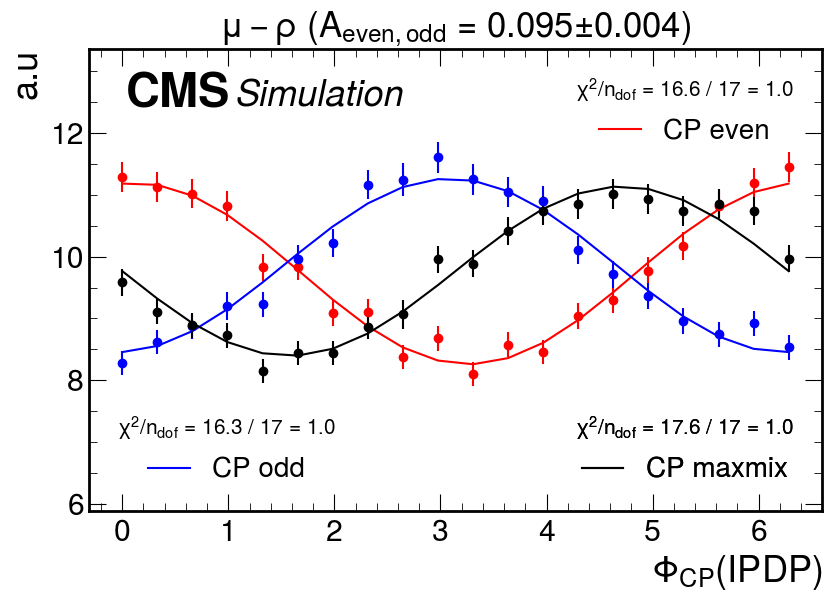

cat :  $\mu-a^{1}_{3\pi}$
hyp :  cp_even shift_props : {'shift': 150, 'colour': 'red', 'location': 'upper right'}
hyp :  cp_odd shift_props : {'shift': 151, 'colour': 'blue', 'location': 'lower left'}
hyp :  cp_maxmix shift_props : {'shift': 0, 'colour': 'black', 'location': 'lower right'}
combo_name :  cp_even_vs_cp_odd
combo_name :  cp_even_vs_cp_maxmix
combo_name :  cp_odd_vs_cp_maxmix


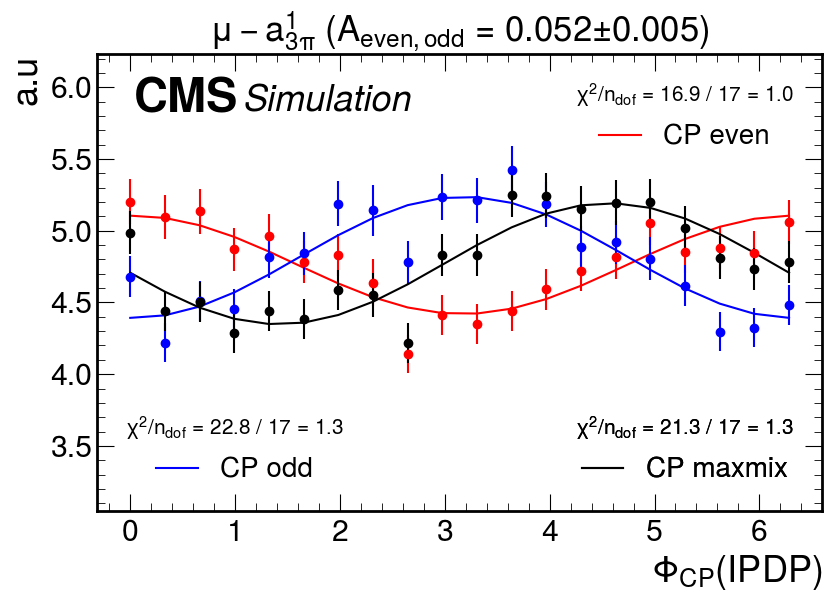

In [394]:
x = np.linspace(0., 2*np.pi, 20)

for cat, val in cparray.items():  # Loop over categories (DMs)
    print("cat : ", cat)
    if len(val) == 0:
        print(f"WARNING : {cat} has an empty dict")
        continue

    plt.figure(figsize=(8.9, 6.6))
    hep.cms.text("Simulation", loc=1)

    # Initialize category in data_storage if not already there
    if cat not in data_storage:
        data_storage[cat] = {
            "tags": {},  # Initialize the tags key to store per-category tags
        }

    for hyp, shift_props in shiftdict.items():  # Loop over hypotheses
        shift, colour, location = shift_props["shift"], shift_props["colour"], shift_props["location"]
        print("hyp : ", hyp, "shift_props :", shift_props)

        hypothesis_zip = val[hyp]  # gives per hypothesis: {'values': array, 'errors': array, '...': 'black', 'location': '...'}
        hypothesis_fit_vals, hypothesis_fit_errs = np.ravel(hypothesis_zip["values"]), np.ravel(hypothesis_zip["errors"])

        # Fit the Hypothesis
        m, err, a, sigma_a, b, sigma_b, c = fit(x, hypothesis_fit_vals, hypothesis_fit_errs)
        
        # Store detailed fit results for each hypothesis within category and tag
        if "tags" not in data_storage[cat]:  
            data_storage[cat]["tags"] = {}  # Ensure "tags" exists
        
        if tag not in data_storage[cat]["tags"]:  
            data_storage[cat]["tags"][tag] = {}  # Initialise tag in [tags] if not already there
        
        data_storage[cat]["tags"][tag][hyp] = {  # Directly use hypothesis name
            "values": hypothesis_fit_vals.tolist(),
            "errors": hypothesis_fit_errs.tolist(),
            "colour": colour,
            "location": location,
            "m": m,
            "err": err,
        }


        # Plot the results
        plt.errorbar(x, hypothesis_fit_vals, hypothesis_fit_errs, fmt="o", color=colour)
        fit_curve = model(x, *m.values)
        plt.plot(x, fit_curve, color=colour)
        fit_info = [
            f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
        ]
        legend_handle = Line2D([0], [0], color=colour, label=f"CP {hyp[3:]}")
        legend = plt.legend(handles=[legend_handle], title="\n".join(fit_info), frameon=False, loc=location, fontsize=20, title_fontsize=15)
        plt.gca().add_artist(legend)

        fit_y_min = np.min(fit_curve)
        fit_y_max = np.max(fit_curve)
        y_min = fit_y_min - 0.3 * fit_y_min
        y_max = fit_y_max + 0.2 * fit_y_max
        plt.ylim(y_min, y_max)

    for category1, category2 in itertools.combinations(shiftdict.keys(), 2):  # Loop over pairs of hypotheses (asymmetry calculations)
        hypothesis1 = np.ravel(val[category1]["values"])
        hypothesis2 = np.ravel(val[category2]["values"])
        error1 = np.ravel(val[category1]["errors"])
        error2 = np.ravel(val[category2]["errors"])

        asymmetry = comp_asymmetry(hypothesis1, hypothesis2)
        asymmetry_error = comp_asymmetry_error(hypothesis1, hypothesis2, error1, error2)

        combo_name = f"{category1}_vs_{category2}"
        print("combo_name : ", combo_name)

        if combo_name not in data_storage[cat]["tags"][tag]:
            data_storage[cat]["tags"][tag][combo_name] = {}  # Initialize combo_name under tag if not already there

        # Store asymmetry result for this category and tag
        data_storage[cat]["tags"][tag][combo_name]["asymmetry_val"] = asymmetry
        data_storage[cat]["tags"][tag][combo_name]["asymmetry_error"] = asymmetry_error


    # Save the final plot
    asymmetry_val_even_odd = data_storage[cat]["tags"][tag]["cp_even_vs_cp_odd"]["asymmetry_val"]
    asymmetry_error_even_odd = data_storage[cat]["tags"][tag]["cp_even_vs_cp_odd"]["asymmetry_error"]
    asymmetry_val_even_odd_rounded = round(asymmetry_val_even_odd, 3)
    asymmetry_error_even_odd_rounded = round(asymmetry_error_even_odd, 3)

    plt.xlabel(r"$\Phi_{CP}$" + f"({tag})")
    plt.ylabel("a.u")
    plt.title(f"{cat} ($A_{{even,odd}}$ = {asymmetry_val_even_odd_rounded}$\pm${asymmetry_error_even_odd_rounded})", fontsize=25, loc='center')
    plt.tight_layout()
    plt.savefig(f"OUTPUT/{tag}_{cat}.pdf", dpi=300)
    plt.show()


In [403]:
data_storage.keys()

dict_keys(['$\\mu-\\rho$', '$\\mu-a^{1}_{3\\pi}$', '$\\mu-\\pi$'])

In [404]:
data_storage['$\\mu-a^{1}_{3\\pi}$'].keys()

dict_keys(['tags'])

In [405]:
data_storage['$\\mu-a^{1}_{3\\pi}$']['tags'].keys()

dict_keys(['IPDP'])

In [406]:
print("data_storage['$\\mu-a^{1}_{3\\pi}$']['tags']['IPPV'].keys() : ", data_storage['$\\mu-\\pi$']['tags']['IPPV'].keys())

KeyError: 'IPPV'

In [407]:
data_storage['$\\mu-a^{1}_{3\\pi}$']['tags']['IPPV']['cp_even'].keys()

KeyError: 'IPPV'

In [408]:
data_storage['$\\mu-a^{1}_{3\\pi}$']['tags']['IPPV']['cp_even']['colour']

KeyError: 'IPPV'

In [409]:
data_storage['$\\mu-a^{1}_{3\\pi}$']['tags']['IPPV']['cp_even_vs_cp_odd'].keys()

KeyError: 'IPPV'

In [410]:
data_storage['$\\mu-a^{1}_{3\\pi}$']['tags']['IPPV']['cp_even_vs_cp_odd']['asymmetry_val']

KeyError: 'IPPV'